<a href="https://colab.research.google.com/github/aruna09/Predict-Future-Sales/blob/master/PredictFutureSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wE1zSgjW2mNhQrFvlUV6L6QK88CxiCjjkeabEq_0kXcYkKBY0Z-jos
Mounted at /content/drive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn 
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path = "/content/drive/My Drive/predict-future-sales"
os.chdir(path)

In [4]:
train = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")
item_cat = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")

In [78]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
train_copy = train[['date', 'date_block_num','shop_id', 'item_id', 'item_price', 'item_cnt_day']].copy()

In [67]:
# no of items sold per month
# Lets check if the components have trend and seasonality

total_sales_permonth = pd.DataFrame()
total_sales_permonth = train.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index()
total_sales_permonth['date_block_num'] = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
total_sales_permonth.head()

,date_block_num,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


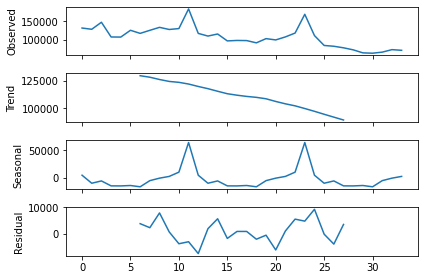

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(total_sales_permonth['item_cnt_day'], model='additive', freq=12)
x = decomposed.plot() 
# A clear seasonality and trend shows both in additive and multiplicative model for No_of__items_sold

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(total_sales_permonth['item_price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
 # The p value indicates no trend.

ADF Statistic: -3.327774
p-value: 0.013682
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


In [ ]:
## For item_cnt_day
from statsmodels.tsa.stattools import adfuller

result = adfuller(total_sales_permonth['item_cnt_day'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
 # the given p value is greater than 1% or 5% and hence the data is not stationary. Now that we know the data is not stationary,
 # the next logical step is to difference the trend from the given feature.

ADF Statistic: -2.395704
p-value: 0.142953
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


In [31]:
# data: dataset
# freq: frequency
# col: column name which has to be made stationary
# common function which takes the frequency to differentiate betwenn trend and seasonality
df = pd.DataFrame()
def make_stationary(data, freq, col):
  frequency = freq
  modified = list()
  for i in range(frequency, len(train)):
    diff = train[col][i] - train[col][i-frequency]
    modified.append(diff)

  modified = pd.Series(modified)
  last_element = pd.Series([train[col][len(train)-1]])
  modified.append(last_element, ignore_index=True)

  stationary_setname = col + "_stationary_set"
 
  df.name = stationary_setname
  df['date'] = total_sales_permonth['date_block_num']
  df['stationary'+col] = modified
  return df

In [32]:
# de-trending item_cnt value
detrended_set = pd.DataFrame()
detrended_set = make_stationary(total_sales_permonth, 1, 'item_cnt_day')

[]

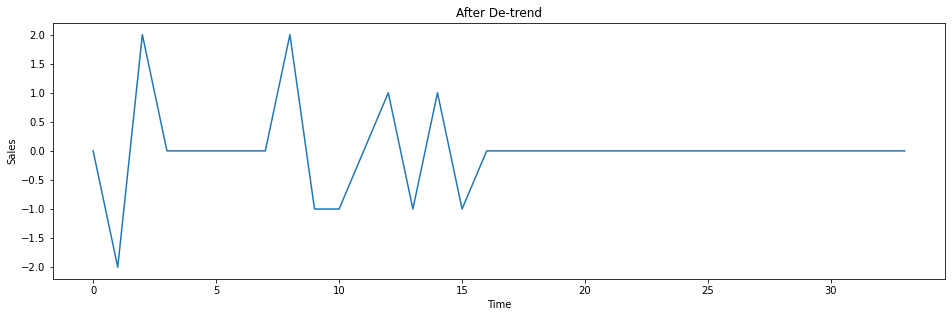

In [35]:
# plotting the de-trended item_cnt_day feature
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(detrended_set['stationaryitem_cnt_day'])
plt.plot()

In [ ]:
# de-seasoned item_cnt value
deseasoned_set = pd.DataFrame()
deseasoned_set = make_stationary(total_sales_permonth, 12, 'item_cnt_day')

[]

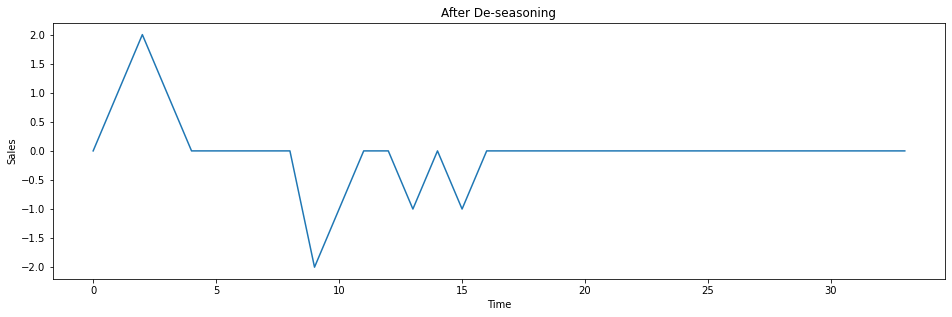

In [50]:
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('After De-seasoning')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(detrended_set['stationaryitem_cnt_day'])
plt.plot()

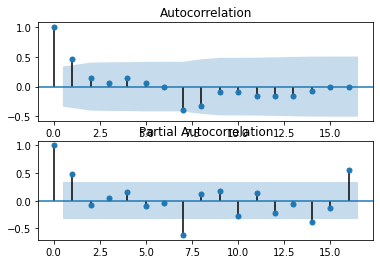

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure()
pyplot.subplot(211)
plot_acf(detrended_set['stationaryitem_cnt_day'], ax=pyplot.gca())

pyplot.subplot(212)
plot_pacf(detrended_set['stationaryitem_cnt_day'], ax=pyplot.gca())
pyplot.show()

From the above ACF and PACF plots, we understand that it is an AR(2) and MA(2) model. Therefore it is ARMA(2,2) model.

                             ARIMA Model Results                              
Dep. Variable:         D.item_cnt_day   No. Observations:                   33
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -375.397
Method:                       css-mle   S.D. of innovations          21016.507
Date:                Wed, 09 Sep 2020   AIC                            760.794
Time:                        11:47:48   BIC                            768.276
Sample:                             1   HQIC                           763.311
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1961.7278   2340.660     -0.838      0.409   -6549.336    2625.881
ar.L1.D.item_cnt_day    -0.4661      0.667     -0.699      0.490      -1.773       0.841
ar.L2.D.item

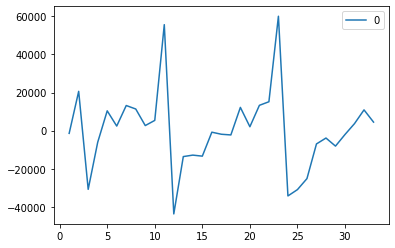

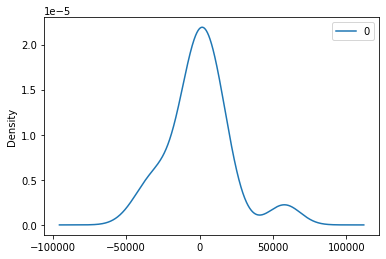

                  0
count     33.000000
mean     153.330865
std    21366.101801
min   -43683.944106
25%    -8115.697360
50%     -813.471155
75%    10882.580097
max    60002.271297


In [77]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# fit model
model = ARIMA(total_sales_permonth['item_cnt_day'], order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

Checking for dependance (aka, correlation) – which is the first assumption for autoregression models. A visual method for checking correlation is to use pandas lag_plot() function to see how well the values of the original sales data are correlated with each other. If they are highly correlated, we’ll see a fairly close grouping of datapoints that align along some point/line on the plot.

https://pythondata.com/forecasting-time-series-autoregression/

This plot does show close clustering and some outliers here and there. Let's check the autocorrelation plot as well 

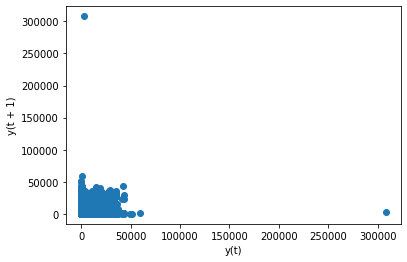

In [ ]:
pd.plotting.lag_plot(train['item_price'])

In [ ]:
train['item_price'].corr(train['item_price'].shift(0))

1.0

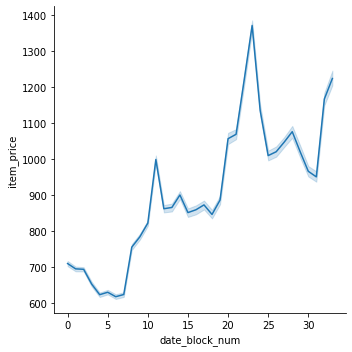

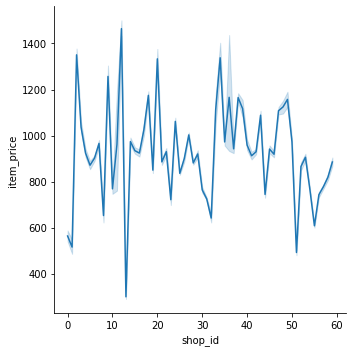

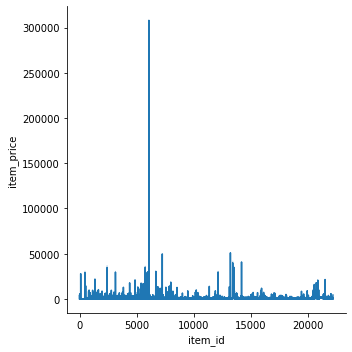

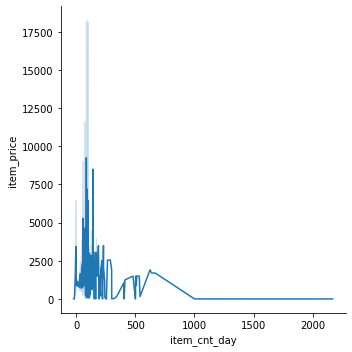

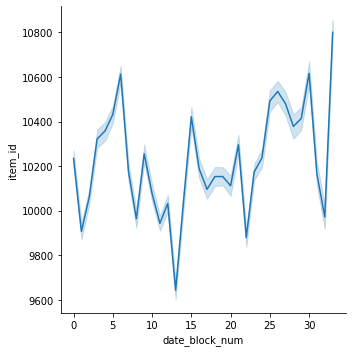

In [ ]:
g = seaborn.relplot(x="date_block_num", y="item_price", kind="line", data=train)
g = seaborn.relplot(x="shop_id", y="item_price", kind="line", data=train)
g = seaborn.relplot(x="item_id", y="item_price", kind="line", data=train)
g = seaborn.relplot(x="item_cnt_day", y="item_price", kind="line", data=train)
g = seaborn.relplot(x="date_block_num", y="item_id", kind="line", data=train)

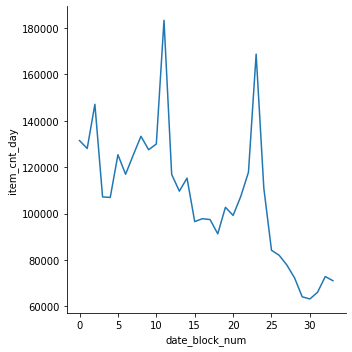

In [ ]:
g = seaborn.relplot(x="date_block_num", y="item_cnt_day", kind="line", data=total_sales_permonth)

# We observe a seasonality 

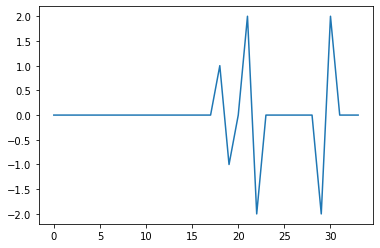

In [ ]:
plt.plot(deseasoned_set['Deseasoned_cnt'])

In [ ]:
make_stationary(train, 1, 'item_cnt_day')

In [ ]:
deseason()

In [ ]:
from sklearn.model_selection import train_test_split

X = grouped_df[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
y = grouped_df['item_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y)


In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# pca.fit_transform(X_train)